## Collect the Data

In [1]:
import pandas as pd
income = pd.read_csv("income.csv")
income.head()

Age  Education  Salary
0   25  Bachelors    43.9
1   30  Bachelors    54.4
2   45  Bachelors    62.5
3   55  Bachelors    72.5
4   65  Bachelors    74.6

## Explore the Data

In [2]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        30 non-null     int64  
 1   Education  30 non-null     object 
 2   Salary     30 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 848.0+ bytes


In [3]:
income.describe()

Age      Salary
count  30.000000   30.000000
mean   43.366667   64.406667
std    14.375466   26.202684
min    24.000000   16.800000
25%    30.500000   46.350000
50%    45.000000   62.100000
75%    55.000000   76.800000
max    65.000000  118.000000

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

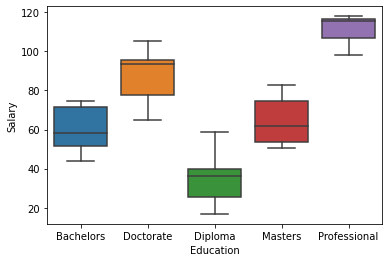

In [5]:
ax = sns.boxplot(data = income, x = 'Education', y = 'Salary')

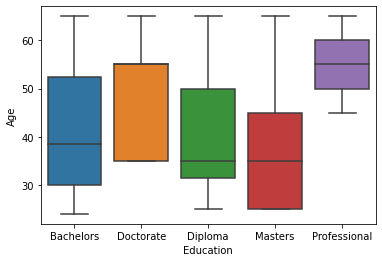

In [6]:
ax = sns.boxplot(data = income, x = 'Education', y = 'Age')

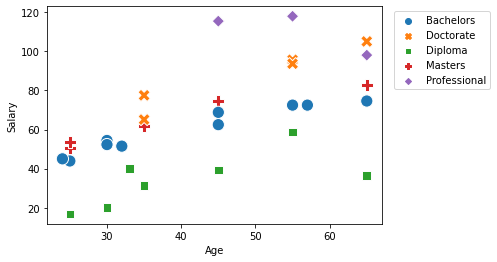

In [7]:
ax = sns.scatterplot(data = income, 
                     x = 'Age', 
                     y = 'Salary', 
                     hue = 'Education', 
                     style = 'Education', 
                     s = 150)
ax = plt.legend(bbox_to_anchor = (1.02, 1), loc = 'upper left')

## Prepare the Data

In [8]:
y = income[['Salary']]

In [9]:
X = income[['Age', 'Education']]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.6,
                                                    stratify = X['Education'],
                                                    random_state = 1234) 

In [11]:
X_train.shape, X_test.shape

((18, 2), (12, 2))

In [12]:
X_train.head()

Age     Education
0    25     Bachelors
16   45       Masters
17   65       Masters
29   65  Professional
8    25       Diploma

In [13]:
X_train = pd.get_dummies(X_train)
X_train.head()

Age  Education_Bachelors  Education_Diploma  Education_Doctorate  \
0    25                    1                  0                    0   
16   45                    0                  0                    0   
17   65                    0                  0                    0   
29   65                    0                  0                    0   
8    25                    0                  1                    0   

    Education_Masters  Education_Professional  
0                   0                       0  
16                  1                       0  
17                  1                       0  
29                  0                       1  
8                   0                       0

In [14]:
X_test = pd.get_dummies(X_test)
X_test.head()

Age  Education_Bachelors  Education_Diploma  Education_Doctorate  \
9    30                    0                  1                    0   
21   25                    0                  0                    0   
4    65                    1                  0                    0   
10   35                    0                  1                    0   
7    65                    0                  0                    1   

    Education_Masters  Education_Professional  
9                   0                       0  
21                  1                       0  
4                   0                       0  
10                  0                       0  
7                   0                       0

## Train and Evaluate the Regression Tree

In [15]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 1234)

In [16]:
model = regressor.fit(X_train, y_train)

In [17]:
model.score(X_test, y_test)

0.5853149222529794

In [18]:
y_test_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_test_pred)

13.541666666666666

## Visualize the Regression Tree

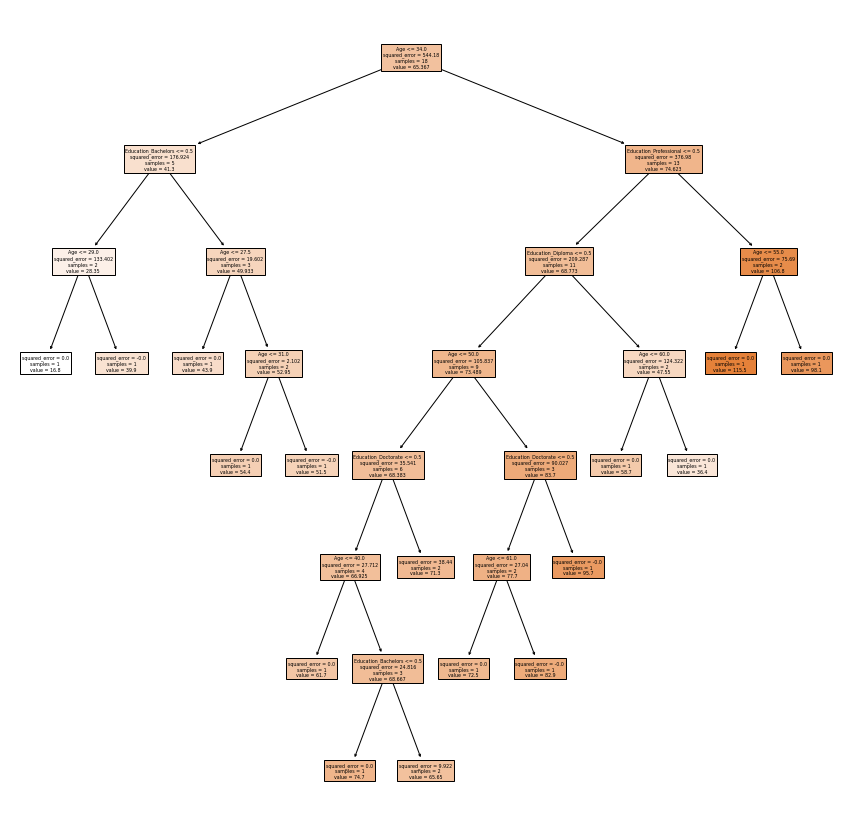

In [20]:
from sklearn import tree
plt.figure(figsize = (15,15))
tree.plot_tree(model, 
                   feature_names = list(X_train.columns), 
                   filled = True);

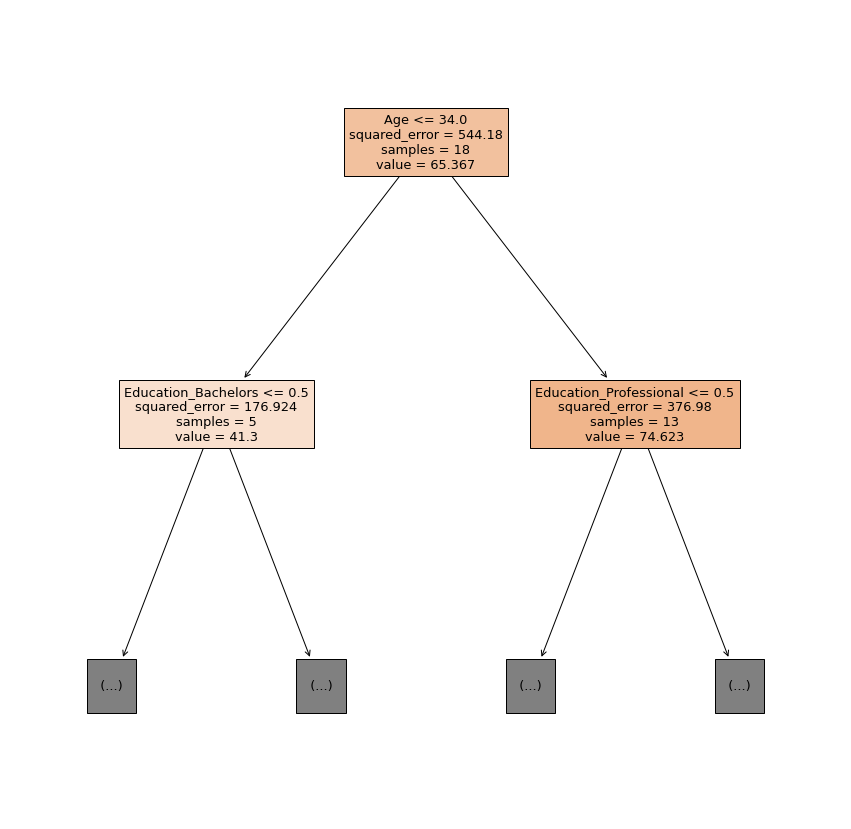

In [21]:
plt.figure(figsize = (15,15))
tree.plot_tree(model, 
               feature_names = list(X_train.columns), 
               filled = True,
               max_depth = 1);

In [22]:
importance = model.feature_importances_
importance

array([0.54597998, 0.06326845, 0.11352129, 0.02490287, 0.        ,
       0.25232742])

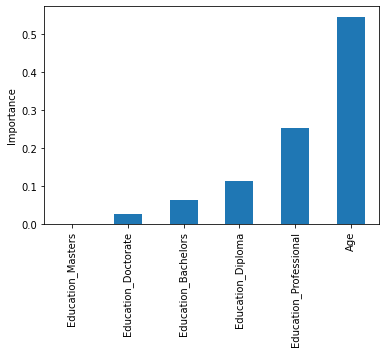

In [23]:
feature_importance = pd.Series(importance, index = X_train.columns)
feature_importance.sort_values().plot(kind = 'bar')
plt.ylabel('Importance');

## Prune the Regression Tree

In [24]:
model.score(X_train, y_train)

0.9901253057607573

In [25]:
model.score(X_test, y_test)

0.5853149222529794

## List of effective alphas for the training data

In [26]:
path = regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
list(ccp_alphas)

[0.0,
 0.23361111111110705,
 2.1578395061724223,
 3.004444444444693,
 3.0334259259259144,
 8.409999999999753,
 12.000000000000506,
 13.813611111110644,
 14.822500000000016,
 26.06669753086468,
 31.05601851851865,
 61.1659960718292,
 135.95562548562512,
 222.77094017094078]

#### We remove the maximum effective alpha because it is the trivial tree with just one node.

In [27]:
ccp_alphas = ccp_alphas[:-1]
list(ccp_alphas)

[0.0,
 0.23361111111110705,
 2.1578395061724223,
 3.004444444444693,
 3.0334259259259144,
 8.409999999999753,
 12.000000000000506,
 13.813611111110644,
 14.822500000000016,
 26.06669753086468,
 31.05601851851865,
 61.1659960718292,
 135.95562548562512]

#### Next, we train several trees using the different values for alpha.

In [29]:
train_scores, test_scores = [], []
for alpha in ccp_alphas:
    regressor_ = DecisionTreeRegressor(random_state = 1234, ccp_alpha = alpha)
    model_ = regressor_.fit(X_train, y_train)
    train_scores.append(model_.score(X_train, y_train))
    test_scores.append(model_.score(X_test, y_test))

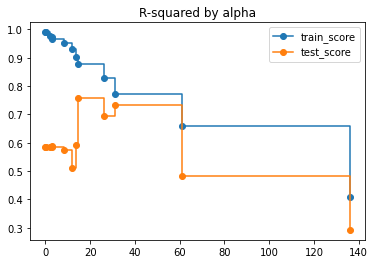

In [30]:
plt.plot(ccp_alphas, 
         train_scores, 
         marker = "o", 
         label = 'train_score', 
         drawstyle = "steps-post")
plt.plot(ccp_alphas, 
         test_scores, 
         marker = "o", 
         label = 'test_score', 
         drawstyle = "steps-post")
plt.legend()
plt.title('R-squared by alpha');

In [31]:
test_scores

[0.5853149222529794,
 0.5857107382012932,
 0.5857107382012932,
 0.5889110156116097,
 0.5861012049128272,
 0.5742699063850475,
 0.5110187660049715,
 0.5901546580161237,
 0.7572572323335666,
 0.6933555316243081,
 0.7328980549684876,
 0.4823659659054369,
 0.2920328593359385]

In [32]:
ix = test_scores.index(max(test_scores))
best_alpha = ccp_alphas[ix]
best_alpha

14.822500000000016

In [33]:
regressor_ = DecisionTreeRegressor(random_state = 1234, ccp_alpha = best_alpha)
model_ = regressor_.fit(X_train, y_train)

In [34]:
model_.score(X_train, y_train)

0.8765762758237674

In [35]:
model_.score(X_test, y_test)

0.7572572323335666

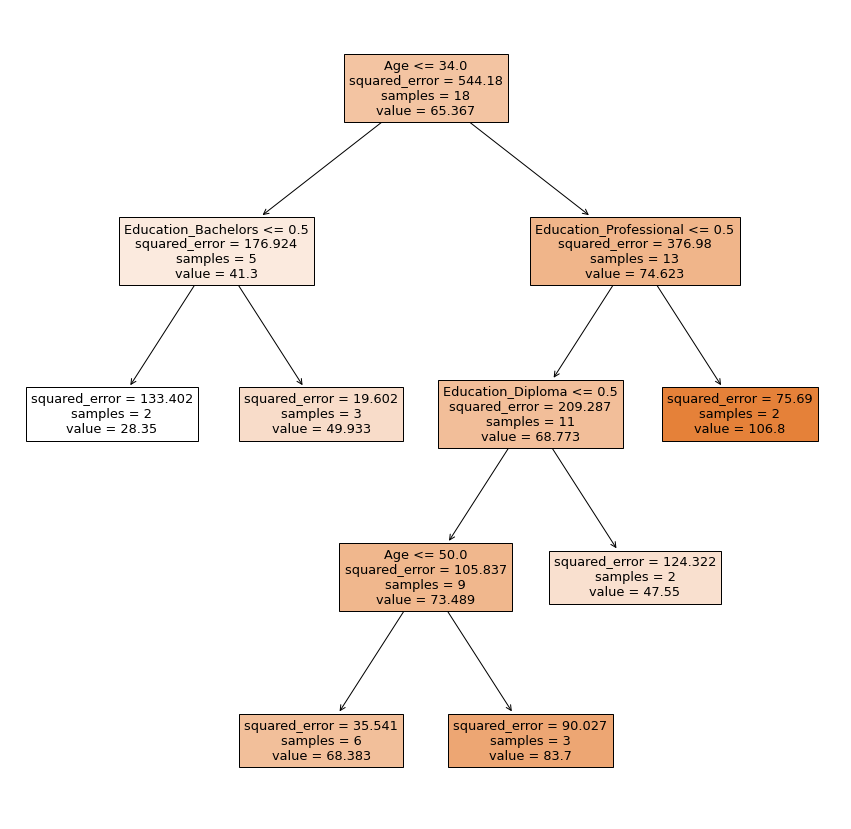

In [36]:
plt.figure(figsize = (15,15))
tree.plot_tree(model_, 
                   feature_names = list(X_train.columns),
                   filled = True);